# Book Recommender System using Goodbooks-10k data set

In [1]:
# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, evaluate, NMF, accuracy
from surprise.model_selection import train_test_split, cross_validate, KFold


In [3]:
# Read in data sets

In [4]:
books = pd.read_csv('books.csv', sep=',', error_bad_lines=False, encoding="latin-1")
ratings = pd.read_csv('ratings.csv', sep=',', error_bad_lines=False)

In [5]:
# Identify books.csv has been read in correctly.
print(books.head())
print(ratings.head())

   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                       authors  original_publication_year  \
0  9.780439e+12               Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPrÃ©                     1997.0   
2  9.780316e+12               Stephenie Meyer                     2005.0   
3  9.780061e+12                    Harper Lee                     1960.0   
4  9.780743e+12           F. Scott Fitzgerald                     1925.0   

                             original_title  \
0              

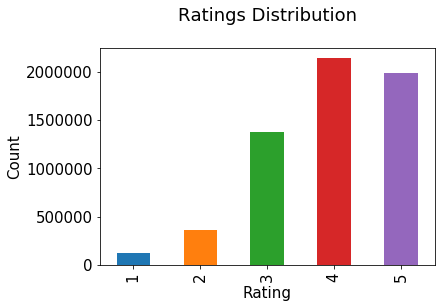

In [6]:
# Visualise rating distribution
plt.rc("font", size=15)
ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Ratings Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Top 10 Most Popular books

In [7]:
# View top 10 most popular rated books
rating_count = pd.DataFrame(ratings.groupby('book_id')['rating'].count())
top_10_books = rating_count.sort_values('rating', ascending=False).head(10)
rating_count.sort_values('rating', ascending=False).head(10)
most_popular_books = pd.DataFrame(top_10_books.index, index = np.arange(10), columns = ["book_id"])
most_popular_books_summary = pd.merge(most_popular_books, books, on="book_id")
most_popular_books_summary["average_rating"].head(10)
most_popular_books_summary[["book_id", "original_title", "average_rating", "ratings_count"]].head(10)

book_id                            original_title  average_rating  \
0        1                          The Hunger Games            4.34   
1        2  Harry Potter and the Philosopher's Stone            4.44   
2        4                     To Kill a Mockingbird            4.25   
3        3                                  Twilight            3.57   
4        5                          The Great Gatsby            3.89   
5       17                             Catching Fire            4.30   
6       20                                Mockingjay            4.03   
7       18  Harry Potter and the Prisoner of Azkaban            4.53   
8       23   Harry Potter and the Chamber of Secrets            4.37   
9        7        The Hobbit or There and Back Again            4.25   

   ratings_count  
0        4780653  
1        4602479  
2        3198671  
3        3866839  
4        2683664  
5        1831039  
6        1719760  
7        1832823  
8        1779331  
9        2071616

## Top 10 highest rated books

In [8]:
# View top 10 highest rated books
rating_mean = pd.DataFrame(ratings.groupby('book_id')['rating'].mean())
top_10_books = rating_mean.sort_values('rating', ascending=False).head(10)
rating_mean.sort_values('rating', ascending=False).head(10)
highest_rated_books = pd.DataFrame(top_10_books.index, index = np.arange(10), columns = ["book_id"])
highest_rated_books_summary = pd.merge(highest_rated_books, books, on="book_id")
highest_rated_books_summary[["book_id", "original_title", "average_rating", "ratings_count"]].head(10)

book_id                                     original_title  average_rating  \
0     3628                     The Complete Calvin and Hobbes            4.82   
1     7947                                                NaN            4.76   
2     9566  Attack of the Deranged Mutant Killer Monster S...            4.72   
3     6920  The Indispensable Calvin and Hobbes: A Calvin ...            4.73   
4     8978  The Revenge of the Baby-Sat: A Calvin and Hobb...            4.71   
5     6361  There's Treasure Everywhere: A Calvin and Hobb...            4.74   
6     6590                The Authoritative Calvin and Hobbes            4.73   
7     4483  It's a Magical World: A Calvin and Hobbes Coll...            4.75   
8     3275                                                NaN            4.77   
9     1788       The Calvin and Hobbes Tenth Anniversary Book            4.63   

   ratings_count  
0          28900  
1           8953  
2           9713  
3          14597  
4          11503  
5          16766  
6          16087  
7          22351  
8          33220  
9          48280

# Building a Pearsons Correlation Recommender system based on Similarity 

In [9]:
user_rating_counts = ratings["user_id"].value_counts()
ratings_with_regular_users = ratings[ratings["user_id"].isin(user_rating_counts[user_rating_counts >=100].index)]
book_rating_counts = ratings_with_regular_users["book_id"].value_counts()
ratings_with_regular_users_and_books = ratings_with_regular_users[ratings_with_regular_users["book_id"].isin(book_rating_counts[book_rating_counts >=100].index)]

In [10]:
ratings_pivot = ratings_with_regular_users_and_books.pivot(index="user_id", columns="book_id", values="rating")
user_id = ratings_pivot.index
book_id = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(37084, 7713)


book_id  1     2     3     4     5     6     7     8     9     10    ...   \
user_id                                                              ...    
1         NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN   4.0  ...    
4         NaN   5.0   NaN   4.0   4.0   NaN   4.0   4.0   NaN   5.0  ...    
5         NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN  ...    
7         NaN   NaN   NaN   NaN   3.0   NaN   NaN   2.0   NaN   NaN  ...    
9         4.0   4.0   4.0   NaN   5.0   NaN   NaN   NaN   1.0   5.0  ...    

book_id  9965  9966  9972  9974  9976  9977  9981  9990  9995  9999  
user_id                                                              
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
9         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 7713 columns]

In [11]:
hobbit_ratings= ratings_pivot[18]
hobbit_ratings.head()
similar_to_hobbit = ratings_pivot.corrwith(hobbit_ratings)
corr_hobbit = pd.DataFrame(similar_to_hobbit, columns=['pearsonR'])
corr_hobbit.dropna(inplace=True)
#corr_summary = corr_hobbit.join()
corr_hobbit.sort_values('pearsonR', ascending=False).head(10)

pearsonR
book_id          
18       1.000000
6825     0.806802
8550     0.747510
8301     0.738201
9403     0.738173
4912     0.724450
7987     0.718581
422      0.711539
23       0.696674
24       0.691343

In [12]:
hobbit_10_most_recommended = corr_hobbit.sort_values('pearsonR', ascending=False).head(10)
hobbit_most_recommended = pd.DataFrame(hobbit_10_most_recommended.index, index = np.arange(10), columns = ["book_id"])
hobbit_most_recommended_summary = pd.merge(hobbit_most_recommended, books, on="book_id")
hobbit_most_recommended_summary[["book_id", "original_title", "authors", "average_rating", "ratings_count"]].head(10)

book_id                                     original_title  \
0       18           Harry Potter and the Prisoner of Azkaban   
1     6825  Care of the Soul : A Guide for Cultivating Dep...   
2     8550                                      Radiant Angel   
3     8301                                  Delusion in Death   
4     9403                                     Indemnity Only   
5     4912                                           Catch Me   
6     7987                                The Hydrogen Sonata   
7      422                    Complete Harry Potter Boxed Set   
8       23            Harry Potter and the Chamber of Secrets   
9       24                Harry Potter and the Goblet of Fire   

                                    authors  average_rating  ratings_count  
0  J.K. Rowling, Mary GrandPrÃ©, Rufus Beck            4.53        1832823  
1                             Thomas  Moore            3.99          12375  
2                            Nelson DeMille            3.84           6590  
3                                 J.D. Robb            4.31          13716  
4                             Sara Paretsky            3.89          11954  
5                              Lisa Gardner            4.17          21486  
6                             Iain M. Banks            4.15          10964  
7                              J.K. Rowling            4.74         190050  
8              J.K. Rowling, Mary GrandPrÃ©            4.37        1779331  
9              J.K. Rowling, Mary GrandPrÃ©            4.53        1753043

# Use scikit-surprise to do Collaborative Filtering using Matrix Factorisation

In [15]:
# Set up reading in ratings data to Surprise
reader = Reader(name=None, line_format=u'user item rating', sep=None, rating_scale=(1, 5), skip_lines=0)
rating_data = Dataset.load_from_df(ratings_with_regular_users_and_books[['user_id', 'book_id', 'rating']], reader)

In [16]:

# sample random trainset and testset
# test set is made of 25% of the ratings.
#trainset, testset = train_test_split(rating_data, test_size=.25)
# Shuffle the dataset
# define a cross-validation iterator
kf = KFold(n_splits=3)

# We'll use the famous SVD algorithm.
algo = SVD()

for trainset, testset in kf.split(rating_data):
    
    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    # Then compute RMSE
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8406
RMSE: 0.8406
RMSE: 0.8411


TypeError: unhashable type: 'list'

In [38]:
print(trainset.)

In [39]:
print(predictions[:10])

[Prediction(uid=25000, iid=8592, r_ui=4.0, est=4.0538905194448756, details={'was_impossible': False}), Prediction(uid=24091, iid=5703, r_ui=4.0, est=3.8764094965418368, details={'was_impossible': False}), Prediction(uid=28286, iid=4515, r_ui=4.0, est=3.724764184640197, details={'was_impossible': False}), Prediction(uid=51486, iid=1319, r_ui=5.0, est=4.565217270151971, details={'was_impossible': False}), Prediction(uid=5420, iid=347, r_ui=4.0, est=3.8778341942209575, details={'was_impossible': False}), Prediction(uid=10835, iid=8032, r_ui=5.0, est=4.360977683734411, details={'was_impossible': False}), Prediction(uid=17003, iid=1293, r_ui=5.0, est=4.125205526554311, details={'was_impossible': False}), Prediction(uid=37107, iid=5163, r_ui=5.0, est=4.742256429916586, details={'was_impossible': False}), Prediction(uid=45388, iid=3512, r_ui=3.0, est=3.8794665503104913, details={'was_impossible': False}), Prediction(uid=42960, iid=4160, r_ui=4.0, est=4.259828874803048, details={'was_impossibl